## Generating Networks with Small World Properties

Models of small world networks have a short average path length and high clustering coefficient. This means, that there are groups of densely connected nodes within which the neighbours of any given node are highly likely to also be neighbours of one another. In addition, the short average path length is the result of a few edges that exist between nodes of otherwise separate clusters, allowing for short traversal between so-called neighbourhoods. 

**Watts-Strogatz Algorithm**

First create a regular network within which each node is connected to its k nearest neighbours 
by undirected edges. For example, a ring lattice.

Each node being joined to its k nearest neighbours in a regular lattice, edges are then reassigned as follows:
- For each edge (i, j) in the lattice, replace the edge with a new connection (i, t) with probability p, where node t is chosen uniformly from the set of all nodes excluding i. 

The random rewiring process, or reassignment of edges, does not increase the number of edges in the graph. 

The Newman variation of the Watts-Strogatz algorithm introduces new random edges without rewiring and increases the total number of edges of those present in the initial lattice. 

The resulting graph for the standard Watts-Strogatz algorithm is not gauranteed to be connected. 

In [1]:
import random 
import itertools
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 

In [2]:
# Return every adjacent pair / edge in the ring lattice 
#       structure 
# Enumerate the edges in a ring lattice of degree k 
def ring_adjacents(nodes, k):
    hk = int(np.floor(k / 2))
    
    edges = []
    for node in nodes:
        # Identify each adjacent node 
        for j in range((node + 1), (node + hk + 1)):
            v = nodes[j % len(nodes)]  # Modulo enforces loop back to start node  
            edges.append((node, v))
    
    return edges

In [3]:
def ring_network(n, k):
    nodes = range(n)
    edges = ring_adjacents(nodes, k)
    
    # Create networkx graph 
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G

In [4]:
def ws_rewire(G, p):
    for i, j in G.edges():
        if random.random() < p:
            G.remove_edge(i, j)
            nodes = [n for n in list(G.nodes) if n != i  and n not in G[i]]
            # Create new edge
            u, v = i, random.choice(nodes)
            G.add_edge(u, v)

In [5]:
# Generate a networkx graph with small world properties (Watts-Strogatz)
def nx_watts_strogatz(n, k, p):
    # Generate the edge list of a ring lattice 
    #     of size n and degree k 
    ring = ring_network(n, k)
    
    # Randomly reassign edges with probability p
    ws_rewire(ring, p)
    
    return ring

In [6]:
G = nx_watts_strogatz(60, 4, 0.25)

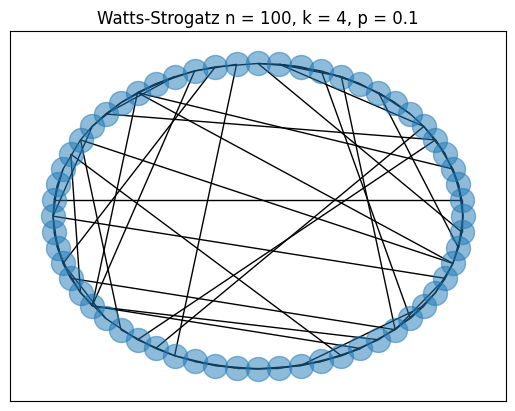

In [8]:
# Define plot layout 
layout = nx.circular_layout(G)

# Plot ring 
plt.figure()
nx.draw_networkx_nodes(G, pos = layout, alpha = 0.5)
nx.draw_networkx_edges(G, pos = layout, edgelist = G.edges)
# Node labels
# nx.draw_networkx_labels(G, layout, font_size=12, font_family="sans-serif")
# Title
plt.title("Watts-Strogatz n = 60, k = 4, p = 0.1")
plt.show()

In [10]:
G_0 = nx_watts_strogatz(60, 4, 0)
G_01 = nx_watts_strogatz(60, 4, 0.1)
G_025 = nx_watts_strogatz(60, 4, 0.25)
G_1= nx_watts_strogatz(60, 4, 1)

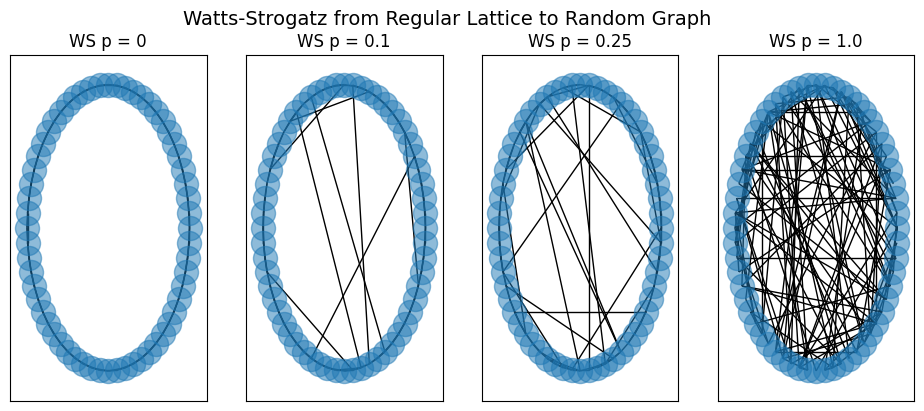

In [18]:
# Define plot layout 
layout = nx.circular_layout(G_0)

# Plot ring 
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(11.67, 4.5))
fig.suptitle('Watts-Strogatz from Regular Lattice to Random Graph', fontsize = 14)
nx.draw_networkx_nodes(G_0, pos = layout, alpha = 0.5, ax=ax1)
nx.draw_networkx_edges(G_0, pos = layout, edgelist = G_0.edges, ax=ax1)

nx.draw_networkx_nodes(G_01, pos = layout, alpha = 0.5, ax=ax2)
nx.draw_networkx_edges(G_01, pos = layout, edgelist = G_01.edges, ax=ax2)

nx.draw_networkx_nodes(G_025, pos = layout, alpha = 0.5, ax=ax3)
nx.draw_networkx_edges(G_025, pos = layout, edgelist = G_025.edges, ax=ax3)

nx.draw_networkx_nodes(G_1, pos = layout, alpha = 0.5, ax=ax4)
nx.draw_networkx_edges(G_1, pos = layout, edgelist = G_1.edges, ax=ax4)

ax1.set_title("WS p = 0")
ax2.set_title("WS p = 0.1")
ax3.set_title("WS p = 0.25")
ax4.set_title("WS p = 1.0")

plt.show()

In [84]:
# Calculate the average clustering coefficient of a networkx graph
# The clustering coefficient of a given node is the fraction of all 
# possible triangles (where neighbours of the node are neighbours of eachother)
# that exist. The average clustering coefficient is the average accross all 
# nodes in the graph. 
def clustering_coefficient(G):
    cc = 0.0
    
    # For neighbours of each node in G
    for n in G.nodes:
        neighbours = list(G[n]) # Obtain the neighbour nodes
        local_edges = [] # List the edges between neighbours of n

        for i in neighbours: # For each neighbour of n 
            for j in list(G[i]): # For each neighbour of i 
                # If the neighbour of i is also neighboured with n 
                #     and the edge hasn't been recorded
                if (n in list(G[j])) and ((j, i) not in local_edges):  
                    local_edges.append((i, j)) 
        
        # n(n-1) / 2 possible unique neighbourhood edges in undirected graph 
        max_edges = (len(neighbours) * (len(neighbours) - 1)) / 2.0
        
        # Fraction of total possible edges 
        if max_edges > 0:
            cc += len(local_edges) / max_edges
        
    return (cc / len(G.nodes))

Run below code block to test the clustering coefficient function on a random WS-graph: 

In [83]:
G = nx_watts_strogatz(24, 4, 0.25)
print("Average Clustering Coefficient: ", clustering_coefficient(G))

Average Clustering Coefficient:  0.31249999999999994


In [281]:
# Compute the shortest paths between all pairs of nodes
# in a weighted, undirected networkx graph 
# Djiksta's algorithm 
def nx_dijkstra(G, source):
    q = []        # Queue nodes to visit in traversal 
    dist = {}     # Distances from source
    prev = {}     # Previous node in path
    
    # Initialise distances to infinity 
    for node in list(G.nodes):
        dist[node] = float('inf')
        prev[node] = None 
        q.append(node) # Queue node for visiting 
    
    dist[source] = 0
    
    while q:
        # Take the node in q with the minimum distance from source
        min_ind, du = None, float('inf')
        for ind, node in enumerate(q):
            if dist[node] < du:
                min_ind, du = ind, dist[node]
        
        # Change u from index to node value
        # Remove u from q 
        u = q.pop(min_ind)
        
        # For every neighbour of u in q
        for v in list(G[u]):
            if v not in q:
                continue 
            
            alt = dist[u] + G[u][v]['weight']
             
            # Select the shortest path to v
            if alt < dist[v]:
                dist[v] = alt
                prev[v] = u
            
    return dist, prev

In [282]:
# Function to calculate the average path length 
# The is the mean of all the shortest paths between 
#     all pairs of vertices 
# The shortest paths are calculated using Djikstra's deterministic algorithm 
def average_path_length(G):
    total_length = 0.0 
    
    # For every source node 
    for src in list(G.nodes):
        # Calculate the shortest path to all other nodes 
        d, p = nx_dijkstra(G, src)
        
        # Add each path length to the total
        total_length += sum(d.values())
    
    # Shortest paths were computed for n(n-1) pairs of nodes
    # Calculate mean path length
    return (total_length / (G.number_of_nodes() * (G.number_of_nodes() - 1)))

In [283]:
# Randomly assign edge weights in range to graph
def assign_random_weight(G, wmin, wmax, w):
    if w is None:
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = random.randint(wmin, wmax)
    else:
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = w

In [176]:
pvalues = [0.0001, 0.000125893, 0.000158489, 0.000199526, 0.000251189, 0.000316228, 0.000398107,
          0.000501187, 0.000630957, 0.000794328, 0.001, 0.001258925, 0.001584893, 0.001995262,
          0.002511886, 0.003162278, 0.003981072, 0.005011872, 0.006309573, 0.007943282, 
          0.01, 0.012589254, 0.015848932, 0.019952623, 0.025118864, 0.031622777, 0.039810717, 0.050118723, 
          0.063095734, 0.079432823, 0.1, 0.125892541, 0.158489319, 0.199526231, 0.251188643, 
          0.316227766, 0.398107171, 0.501187234, 0.630957344, 0.794328235, 1]

In [288]:
# Generate ten random watts-strogatz models for each probability parameter 
ws_clustering = []
ws_pathlength = []

for p in pvalues:
    g = nx_watts_strogatz(n = 1000, k = 10, p=p)
    assign_random_weight(g, 0, 0, 1) # Set edge weights to one
                                     # Dijkstra's will find path with fewest edges 
 
    ws_clustering.append(clustering_coefficient(g))
    ws_pathlength.append(average_path_length(g)) # Find path length as number of edges in path

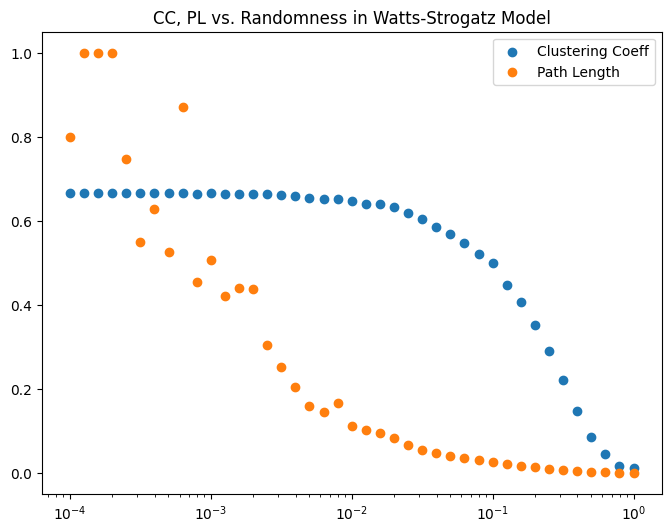

In [303]:
# Normalise path length for plot 
_ws_pathlength = (ws_pathlength - np.min(ws_pathlength)) / (np.max(ws_pathlength) 
                                                            - np.min(ws_pathlength))

fig = plt.figure()
gcx = plt.gca()
fig.set_size_inches(8, 6)
plt.title("CC, PL vs. Randomness in Watts-Strogatz Model")
gcx.scatter(pvalues, ws_clustering, label="Clustering Coeff")
gcx.scatter(pvalues, _ws_pathlength, label="Path Length")
gcx.set_xscale('log')
gcx.legend()



fig.savefig("ws_statistics.jpg", dpi=150)

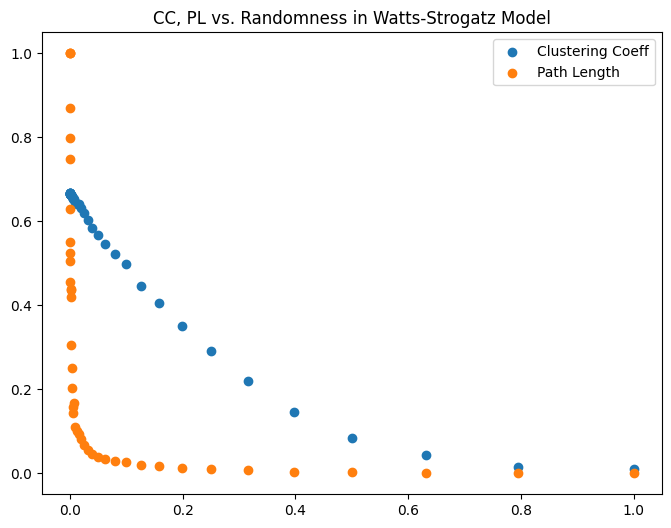

In [304]:
# Normalise path length for plot 
_ws_pathlength = (ws_pathlength - np.min(ws_pathlength)) / (np.max(ws_pathlength) 
                                                            - np.min(ws_pathlength))

fig = plt.figure()
gcx = plt.gca()
fig.set_size_inches(8, 6)
plt.title("CC, PL vs. Randomness in Watts-Strogatz Model")
gcx.scatter(pvalues, ws_clustering, label="Clustering Coeff")
gcx.scatter(pvalues, _ws_pathlength, label="Path Length")
#gcx.set_xscale('log')
gcx.legend()



fig.savefig("ws_statistics.jpg", dpi=150)